*RAPPORT - Data Analysis Project - Simon VAUCLARE - M2 SCAHC*

*Ce PDF est une version simplifiée de "VAUCLARE_Simon.ipynb". Ce notebook est entièrement fonctionnel et contient les codes retirés ici. J'ai obtenu un PDF de 35 pages et j'ai donc préféré retirer du code (remplacé par "... code ...", pour que le rapport reste lisible, j'espère ne pas en avoir trop retiré.*

# Présentation du problème physique

## Introduction

Nous allons utiliser ici les produits SWOT de Sea Surface Height (**SSH**). Ces données ont pour application notamment la création de courants géostrophiques, et bien d'autres.

Cependant, elles doivent faire l'objet d'un traitement pour retirer au mieux possible les erreurs liées au bruit. L'application faite ici se base donc sur un bruit ajouté artificiellement, qui sera, comme attendu, non correlé spatialement.

## Les données

Les données utilisées sont produites artificiellement, et nous avons à disposition un cycle orbital SWOT, le cycle 13, avec ses 270 passes. Le format des données est de deux bandes paralèlles de 8000km de long, pour chacune 60 kilomètres de large. Chaque pixels fait 2km de côté. Les données bruitées sont **ssh_karin**, celles sans bruit sont **ssh_true**. Voici un exemple pour la 5ème passe :

![Figure Exemple 1](./Saves/Figures/1_show_data.png)

# Méthode appliquée

La question se pose désormais du **débruitage**. Nous allons procéder en utilisant d'abord une méthode basique de référence : créer et appliquer une moyenne glissante que nous améliorerons autant que possible. Ensuite, nous explorerons des méthodes de Machine Learning que nous comparerons à la moyenne glissante en termes d'efficacité.


Pour mettre en place le Machine Learning, nous devons d'abord passer par une étape chronophage de traitement des données. Les images contiennent de nombreuses valeurs non définies, représentées par "NaN" (pour Not A Number). Le processus suivi sera :

1. Découpage des images en deux pour séparer les deux bandes parallèles (*voir Figure 1*).
   
   **Figure 1 :** Découpage (exemple avec `ssh_true`) en deux images parallèles : 1 et 2

![Figure Exemple 1](./Saves/Figures/2_1_show_cutting.png)

2. Coupe des images en tronçons de longueur choisie.

3. Conservation de chaque sous-image uniquement si elle ne comporte aucun NaN (*voir figure 2.a et 2.b*)

   - **Figure 2.a :** Exemple d'une image non conservée

![Figure Exemple 1](./Saves/Figures/2_2_14_show_cutting.png)

   - **Figure 2.b :** Exemple d'une image conservée

![Figure Exemple 1](./Saves/Figures/2_2_15_show_cutting.png)

Ces étapes nous permettront d'avoir des données prêtes pour l'application de méthodes de Machine Learning.


* Le Machine Learning présente de nombreux avantages, mais offre aussi tant de possibilités qu'il est facile de se perdre dans trop de voies. Nous faisons le choix ici de rester sur une base de CNN simple, que nous essaierons de compléxifier petit à petit. Nous procéderons donc en testant un à un les paramètres de ce modèle simplistes : 

1. Impact du nombre de Couches Convolutives & de Dropout
3. Impact du Batch Size
4. Impact de la taille du filtre convolutif
5. Impact du choix de la fonction d'activation
6. Impact de l'ajout de Max Pooling

Nous comparerons les **loss**, ou **pertes**, des différents modèles créés pour choisir quelle valeur du paramètre garder. Cette perte est l'écart entre les prédictions faites par le modèle et les valeurs réelles : nous voulons donc la minimiser. Il y a deux types de loss, nous choisissons de comparer celle de validation afin de comparer la performance réelle du modèle, et non pas celle sur le jeu où il a été entraîné.

* Nous essaierons ensuite de mettre en place un modèle plus complexe, dit d'**autoencodeur**, sans tester ses différents paramètres, pour voir s'il fonctionne mieux que la méthode réalisée au-dessus. J'ai passé beaucoup de temps sur cette méthode au début de mon projet, et je trouvais ça intéressant de le conserver pour une comparaison.

Le principe des **autoencodeur** est en trois parties : d'abord un **encodeur** qui comprese les données d'entrées, puis un **espace latent** qui représente les données condensées, et enfin un **décodeur** qui lui va restaurer les données originales à partir de cet espace latent.

* Pour finir, nous allons quantifier la performance des modèles avec la mean squared error, ou MSE, une mesure couramment utilisée et qui mesure la moyenne des carrés des différences, pixel par pixel, entre l'image originale et celle lissée. Cela nous permettra de voir, à la fin, quel modèle est le plus efficace sur le jeu de test.

# Code

## Préparer les données

### Découpage des données

Dans un premier temps, nous allons nous occuper de découper les données, comme expliqué précédemment :

In [5]:
# Paramètres modifiables
number_of_images = 270   # = nombre d'images à utiliser (270 au total)
longeur_image = 52       # en kilomètres => ATTENTION : 1 pixel = 2 km, donc 26 pixels = 52km)

# Paramètres imposés
longueur_img = longeur_image//2 # en km - Automatique
largeur_img = 26               # en km - Par défaut (26 choisi au début au lieu de 30 par praticité pour l'autoencodeur)

In [ ]:
# Découpage des données

list_of_inputs = sorted(glob.glob('./Inputs/input_ssh_karin_013_*.nc')) # 270 passages en tout
img_list = []
keep_count_tot = 0

for i in range(number_of_images):
    swt_input = SwotTrack(list_of_inputs[i]) # Choisir le ième cycle sur 270
    
    ds = swt_input._dset
    ds['num_lines'] = 2*(ds['num_lines']-ds['num_lines'][0]) # On passe de pixels à kilomètres
    ds['num_pixels'] = 2*ds['num_pixels']                    # On passe de pixels à kilomètres

    for lmin,lmax in [10,60],[80,130]: # On va couper en deux l'image, de 10 à 60 puis de 80 à 130 => 26 pixels (= 52km)
        ds_line = ds.where((ds.num_pixels >= lmin) & (ds.num_pixels <= lmax),drop=True) 

        min = 0                                               # min et max, les bornes de longueur de chaque nouvelle image
        max = min + longeur_image
        n_boxes = ds_line.num_lines[-1].values//longeur_image # nombre d'images à faire en longueur
        keep_count = 0                                        # Pour compter le nombre d'images total et vérifier que pas d'erreurs
        
        for j in range(n_boxes): 
            ds_new_line = ds_line.where((ds_line.num_lines >= min) & (ds_line.num_lines < max),drop=True)
    
            if np.sum(np.isnan(ds_new_line.ssh_true)).values==0: # Si pas de NaN, on prend l'image !
                keep_count += 1
                img_list.append(ds_new_line)
                
            min += longeur_image # On augmente les bornes pour passer à l'image suivante
            max += longeur_image
    
        keep_count_tot += keep_count

    if (i+1)%10==0:
        print('Image '+str(i+1)+' traitée') # Suivi du travail en cours

# Quelques vérifications : 

if keep_count_tot != len(img_list): # Si compte d'image pas égale au nombre d'image, alors il y a une erreur dans le code.
    print('ERREUR')

In [ ]:
# Traitement des données et vérification que le format est similaire partout
... code ...

# Sauvegarde des données (on se sert d'une fonction créée et stockée en fichier ".py")
... code ...

### Traitement des données

Ensuite, nous allons préparer les données pour le Machine Learning, nous allons donc créer un jeu **train**, pour l'entraînement du modèle, et un jeu **test**, pour le tester à la fin.

In [ ]:
# Ouvrir les données
... code ...

# Réduire le jeu de données (utile au commencement du projet, on ne s'en sert pas pour le run final)
... code ...

# Séparer Train / Test
... code ...

# Normaliser les images
... code ...

# Normaliser les images
... code ...

Nos jeux de données sont désormais prêts, nous n'avons plus qu'à nous lancer dans le débruitage. Cette partie m'a pris beaucoup de temps à mettre en place, surtout à cause de la découpe d'image que je n'avais pas pensé à faire au début.

## Moyenne Glissante

Commençons par mettre en place une moyenne glissante la plus efficace possible pour débruiter. Nous comparerons ensuite les autres méthodes à celle-ci pour voir si la mise en place d'un type de Machine Learning a un intérêt ou non.

### Mise en place

In [17]:
def moyenne_glissante(image, taille_fenetre_ind): # Cette fonction est la moyenne glissante, elle prend en entrée l'image à filtrer, et la taille de la fenêtre.
    hauteur, largeur, canaux = image.shape
    image_lisse = np.zeros_like(image)

    for c in range(canaux):  # Mise en place de la moyenne glissante
        for i in range(hauteur):
            for j in range(largeur):
                debut_i = max(0, i - taille_fenetre_ind // 2)
                fin_i = min(hauteur, i + taille_fenetre_ind // 2 + 1)
                debut_j = max(0, j - taille_fenetre_ind // 2)
                fin_j = min(largeur, j + taille_fenetre_ind // 2 + 1)

                voisinage = image[debut_i:fin_i, debut_j:fin_j, c]
                moyenne = np.mean(voisinage)
                image_lisse[i, j, c] = moyenne

    return image_lisse

def true_taille_fenêtre(index): # Cette fonction donne la vraie taille de la fenêtre en fonction de l'index fourni
    return (2+((index//2)*2))

def mean_squared_error(cible, lisse): # Cette fonction permet de calculer la MSE
    return np.mean((cible - lisse) ** 2)

**Remarque** : L'index de fenêtre fourni à la moyenne glissante n'est pas la taille de la fenêtre :

* taille_fenetre_ind = 0 & 1 **=>** fenêtre de 2x2
* taille_fenetre_ind = 2 & 3 **=>** fenêtre de 4x4
* taille_fenetre_ind = 4 & 5 **=>** fenêtre de 6x6
* ...

### Choix de la taille de fenêtre

Le code ci-dessous va calculer la MSE pour chaque taille de fenêtre, et nous garderons la taille la plus efficace.

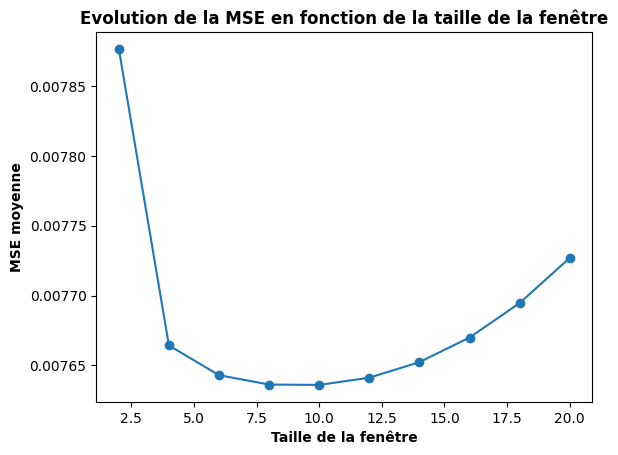

In [11]:
... code ...

Nous pouvons le voir dans le graphique ci-dessus : la taille de fenêtre la plus efficace est de **10 pixels**. Nous gardons donc cette valeur pour la suite.

Observons le résultat d'une mauvaise taille de fenêtre comparée à la meilleure : 

/home/bertrava/Bureau/SIMON_VAUCLARE/2022a_SWOT_karin_error_filtering/VAUCLARE_Simon/Fonctions/Plots_main.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


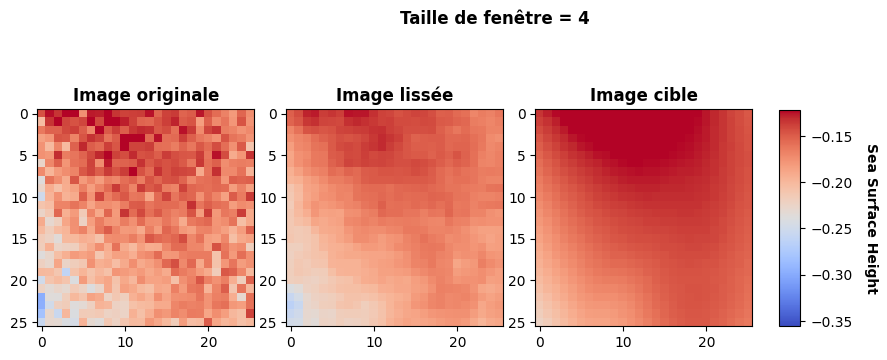

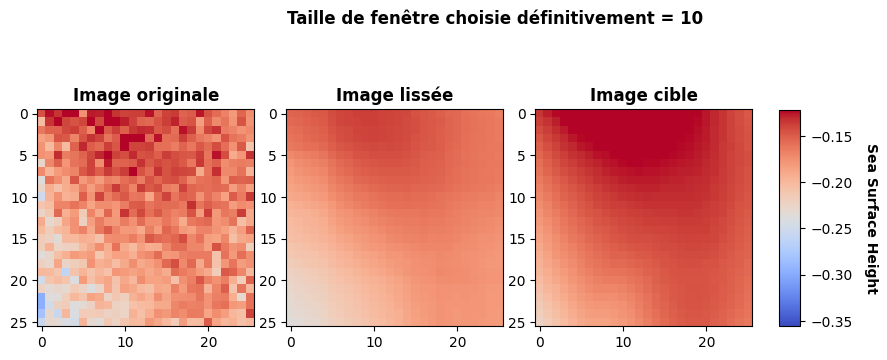

In [13]:
# Code basique pour comparaison des images :
... code ...

On voit, par ce graphique, à quel point l'analyse statistique est nécessaire. En effet, une observation à l'oeil nu ne permet que difficilement de choisir entre les deux méthodes.

## CNN Basique

Nous allons désormais, comme expliqué plus tôt, passer à la complexification et l'amélioration progressives d'un modèle CNN (Convolutional neural network) basique, en commençant par mettre en place quelques fonctions de base.

**Attention** : Le but est ici d'améliorer à chaque fois notre modèle. Ainsi, chaque nouveau paramètre idéal trouvé, est réutilisé dans la suite pour obtenir, à la fin, un modèle amélioré autant que possible dans notre cas.

### Préparation

In [14]:
# Cette fonction crée les modèles de machine learning qui seront entraînés
def build_model(long, larg, num_conv_layers, dropout_rate=0.25, filter = 2, activ_fc = 'relu', add=False):
    model = keras.models.Sequential()                    # On crée le modèle
    model.add(keras.layers.Input(shape=(long, larg, 1))) # Couche d'input

    for _ in range(num_conv_layers):  # Selon le nombre demandé, on ajoute des couches de convolution et de dropout
        if add == True:               # Si add est True, on va ajouter du MaxPooling en plus des convolutions et dropout (voir partie 3.5)
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(32, (filter, filter), activation=activ_fc, padding='same')) # La couche de convolution
        if add == True:
            model.add(keras.layers.UpSampling2D(size=(2, 2))) # Réaugmenter l'image en cas de Max Pooling
        model.add(keras.layers.Dropout(dropout_rate))         # Couche de dropout : elle permet d'éteindre un pourcentage du réseau de neurones à chaque itération

    model.add(keras.layers.Conv2D(1, (filter, filter), activation=None, padding='same'))       # Couche finale

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error']) # Compilation du modèle
    return model

# Petite fonction pour comparer les résultats
def plot_compare(list_x,train,val,xlabel,title):
    plt.figure()
    plt.plot(list_x,train, label='Train loss')
    plt.plot(list_x,val, label='Validation loss')
    plt.xlabel(xlabel,fontweight='bold')
    plt.ylabel('Loss',fontweight='bold')
    plt.legend()
    plt.grid()
    plt.title(title, y=1.05,fontweight = 'bold')
    plt.show()

### Impact du nombre de couches Convolutives & Dropout

**Dans ce test, on va aller d'un modèle avec une couche** : 
* 1 couhe de ce type : *conv2d (Conv2D)             (None, 26, 26, 1)*

**Jusqu'à atteindre un modèle plus compliqué** : 

* 1 couche de ce type : *conv2d_1 (Conv2D)           (None, 26, 26, 32)*
                                                                  
* Suivie de 4 fois : *dropout (Dropout)           (None, 26, 26, 32) **&** conv2d_2 (Conv2D)           (None, 26, 26, 32)*

**Remarques :**          

* Une **couche convolutive 2D** applique une convolution sur les données d'entrées.
* Une **couche de dropout** désactive aléatoirement un certain pourcentage de neurones pendant chaque itération. Elles permettent en général d'éviter le suraprentissage.

**Je ne laisse le code principal que pour l'exemple des Couches Convolutives & Dropout. Il est à peu près similaire pour les autres parties, mais ce n'est pas nécessaire de le montrer à chaque fois**

In [ ]:
# Faisons tourner le modèle pour trouver le meilleur nombre de couches :

best_model, best_val_loss, train_losses, val_losses = None, float('inf'), [], []
colors_train = ['darkblue','blue','grey','orange','red']

for num_layers in range(5):
    print('Travail pour ', num_layers+1, ' couches...')
    train_loss, val_loss, current_model = train_and_plot(X_train, Y_train, longueur_img, largeur_img, num_layers,colors_train[num_layers]) # Les fonctions train_and_plot sont stockées en ".py"
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Sélectionner le meilleur modèle basé sur la perte de validation
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = current_model
        best_number_of_layers_index = num_layers

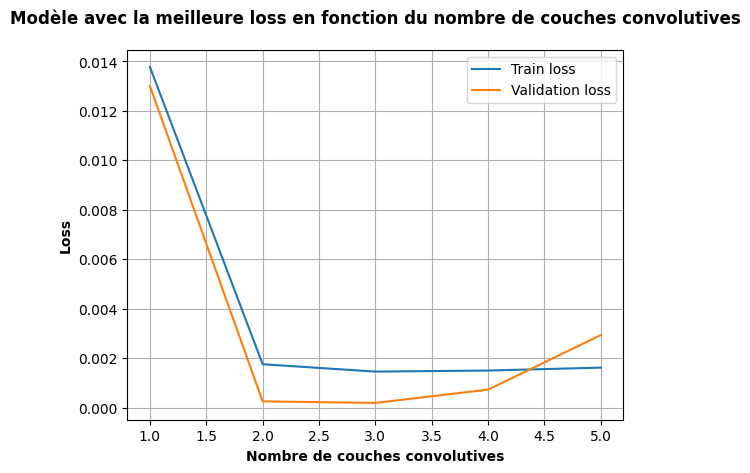

In [14]:
plot_compare([1,2,3,4,5],train_losses, val_losses, 'Nombre de couches convolutives','Loss en fonction du nombre de couches convolutives')

**Analyse du résultat** :

Le modèle tend à tomber dans le suraprentissage (*validation loss supérieure à train loss*) plus on ajoute de couches convolutives, et ce malgré la présence de couches de dropout. 

Avoir un modèle avec trop de paramètres est donc une mauvaise idée dans notre cas, et cela semble logique à la vue de la relative complexité du problème demandé au modèle - c'est-à-dire débruiter chaque pixel par rapport à ses voisins.

Le meilleur modèle est ici celui avec 3 couches.

In [22]:
# Code pour faire prédiction, estimer MSE et faire quelques sauvegardes

... code ...

Nous gardons donc 3 couches convolutives comme meilleur résultat.

88/88 [==============================] - 1s 6ms/step

MSE avec meilleure moyenne glissante           = 7.64e-03
MSE avec meilleur CNN basique (Conv & Dropout) = 7.07e-04


**Commentaire** :

* Ce premier résultat est satisfaisant : avec ce CNN et son nombre de couches idéal, nous avons réussi à baisser la MSE d'un facteur 10. Continuons avec d'autres paramètres !

### Impact de la taille de batch (batch size)

Dans ce test, nous allons faire varier la taille du **batch size** de 10 à 100, en conservant bien-sûr le meilleur nombre de couches trouvé précédemment. Par défaut, le modèle précédent a tourné avec un batch size égal à 80.

**Remarque :**          

* Le **Batch Size** est le nombre d'échantillons utilisés lors de chaque entraînement.

In [ ]:
# Faisons tourner le modèle pour trouver le meilleur batch size :
... code ...

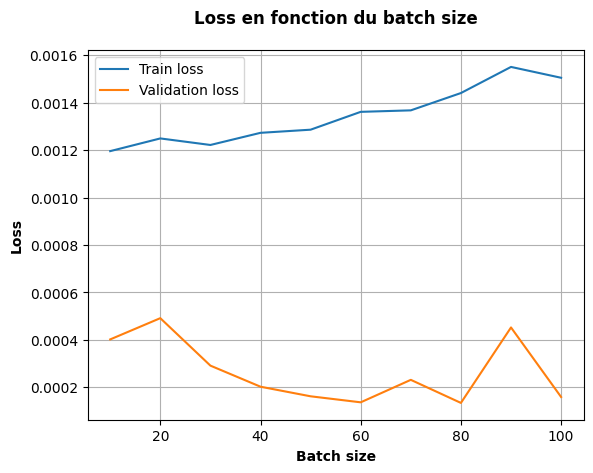

In [29]:
plot_compare([10,20,30,40,50,60,70,80,90,100],train_losses, val_losses, 'Batch size','Loss en fonction du batch size')

**Analyse** :

J'ai eu du mal à interpréter ce résultat. D'un côté, on améliore la loss de validation, alors que celle de train baisse. J'ai choisi de forcer le modèle à garder un batch_size de 40, pour avoir une valeur intérmédiaire, et bonne en train et validation.

In [23]:
... code ...

La taille de batch size idéale semble donc être, dans notre cas, de 40 .

88/88 [==============================] - 1s 5ms/step

MSE avec meilleur CNN basique selon nombre couches Conv et Dropout = 7.07e-04
MSE avec meilleur CNN basique selon batch size                     = 1.01e-04


**Bilan**

Nous avons à nouveau amélioré notre modèle, en passant de 7e-4 à 1e-4.

**Remarque** : une partie du travail a consisté à estimer le temps d'entraînement et de prédiction en fonction des différents paramètres.

* **Temps d'entraînement** - le batch size et le nombre de couches convolutives / dropout faisaient considérablement varier le temps d'entraînement du modèle, mais nous préférons ne pas tenir compte de ceci, car une fois l'entraînement terminé, le modèle est prêt à être utilisé autant qu'on le voudra. C'est une étape qui n'est faite qu'une fois, il est donc acceptable qu'elle soit longue.

* **Temps de prédiction** - Nous n'avons trouvé aucune différence notable de ce temps entre les différentes valeurs de batch size et de nombre de couches convolutives / dropout.

Ainsi, le temps n'est pas un critère qui nous permet de discriminer une quelconque méthode ou valeur testée.

### Impact de la taille du filtre convolutif

**Rappel** : en accord avec les deux sections précédentes, nous nous basons sur une architecture avec trois couches convolutives et un entraînement avec un batch size de 80. Nous réutilisons donc les deux variables : **best_number_of_layers_index** & **best_batch_size**.

**Nous allons cette fois tester une taille de filtre de 1x1 à 10x10.**

**Remarque :**

* Le **filtre convolutif** est une matrice de poids appliquée sur une zone des inputs. Nous proposons ici de changer sa taille.

In [ ]:
# Faisons tourner le modèle pour trouver la meilleure taille de filtre :

... code ...

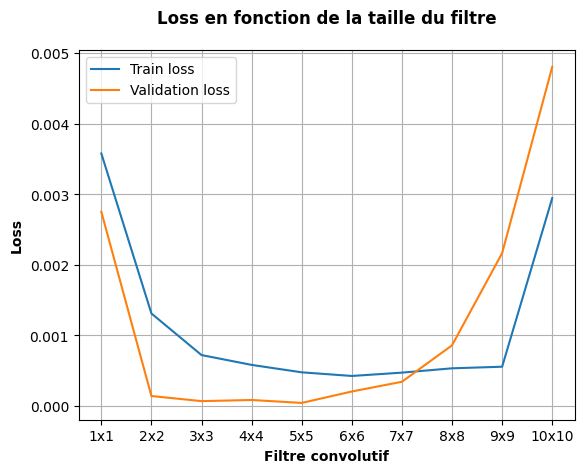

In [22]:
plot_compare(['1x1','2x2','3x3','4x4','5x5','6x6','7x7','8x8','9x9','10x10'],train_losses, val_losses, 'Filtre convolutif','Loss en fonction de la taille du filtre')

**Analyse** :

Cette fois, le résultat est assez clair, et la loss est la plus faible pour le filtre de 5x5.

In [27]:
... code ...

Le filtre idéal semble donc être, dans notre cas, de 5 x 5 .

88/88 [==============================] - 1s 6ms/step

MSE avec meilleur CNN basique selon nombre couches & batch sze = 1.01e-04
MSE avec meilleur CNN basique selon filtre convolutif          = 4.39e-05


**Bilan :**

Une fois de plus, améliorer un paramètre nous fait gagner presque un facteur 10 en terme de MSE. Continuons avec un autre paramètre !

### Impact du choix de la fonction d'activation

Comme d'habitude, nous réutilisons les meilleurs paramètres trouvés précédemment. Cette fois nous allons tester l'impact de différentes **fonctions d'activations** (elle calculent, en sotie de neurone, la valeur de sortie)

**Remarque :**

* Une **fonction d'activation** est simplement une fonction, en termes mathématiques, que l'on utilise pour modifer les données de sortie des neurones. Il en existe plusieurs types, mais nous utilisons ici :
    - **Linear** (identité)
    - **Sigmoid** (transforme en intervalle [0, 1])
    - **ReLU** (max(0, x))
    - **Tanh** (transforme en intervalle [-1, 1])

In [ ]:
# Faisons tourner le modèle pour trouver la meilleure taille de filtre :

... code ...

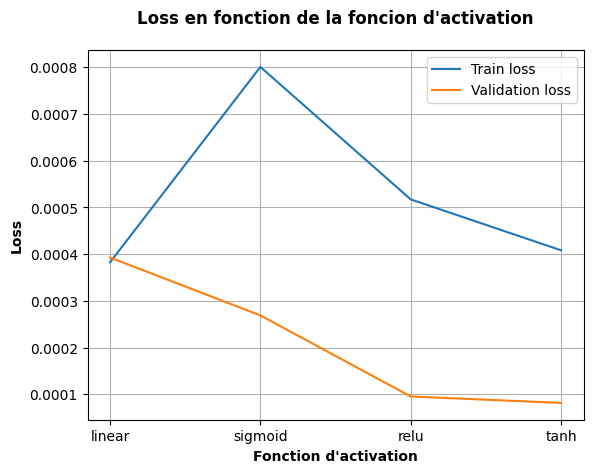

In [29]:
plot_compare(['linear','sigmoid','relu','tanh'],train_losses, val_losses, "Fonction d'activation","Loss en fonction de la foncion d'activation")

**Analyse :**

Ici, les fonctions "relu" et "tanh" semblent être toutes deux efficaces, cependant tanh a une loss inférieure.

In [30]:
... code ...

La meilleure fonction d'activation semble donc être : tanh 

88/88 [==============================] - 1s 6ms/step

MSE avec ancien meilleur CNN  = 4.39e-05
MSE avec nouveau meilleur CNN = 2.84e-05


**Bilan :**

Nous avons réussi à nouveau à améliorer notre MSE, presque en la divisant par deux. Continuons !

### Impact de l'ajout de couches de Max Pooling

**Explication** : 

Cette fois, nous allons faire un test différent. Nous allons comparer pour 1, 2 et 3 couches de Convolution et Dropout, les loss avec et sans insertions de Max Pooling entre elles. Nous gardons toujours les meilleurs paramètres trouvés précédemment.

**Remarque :**

* Le **Max Pooling** va réduire spatiallemet les images en appliquant une fenêtre de 2x2 dans notre cas. Sur cette zone, on ne conservera que la valeur maximale.

In [31]:
# Faisons tourner le modèle pour trouver la meilleure taille de filtre :

best_model, best_val_loss = None, float('inf')

train_losses_no_pooling = []
val_losses_no_pooling = []

train_losses_pooling = []
val_losses_pooling = []

colors_train = ['blue', 'turquoise', 'coral', 'maroon']

i = 0

for nb_layer in [1,2,3]: # On essaie avec 1,2 et 3 couches convolutives dans le modèle
    print("Travail",nb_layer,'/ 3 ...')

    # Premier run : sans pooling
    train_loss, val_loss, current_model = train_and_plot_5(X_train, Y_train, longueur_img, largeur_img, nb_layer,colors_train[i],best_filter, best_fc, add_choix = False, batch_sz=best_batch_size)
    train_losses_no_pooling.append(train_loss)
    val_losses_no_pooling.append(val_loss)
    
    # Deuième run : avec pooling
    train_loss, val_loss, current_model = train_and_plot_5(X_train, Y_train, longueur_img, largeur_img, nb_layer,colors_train[i],best_filter, best_fc, add_choix = True, batch_sz=best_batch_size)
    train_losses_pooling.append(train_loss)
    val_losses_pooling.append(val_loss)
    
    i+= 1

Travail 1 / 3 ...
Travail 2 / 3 ...
Travail 3 / 3 ...


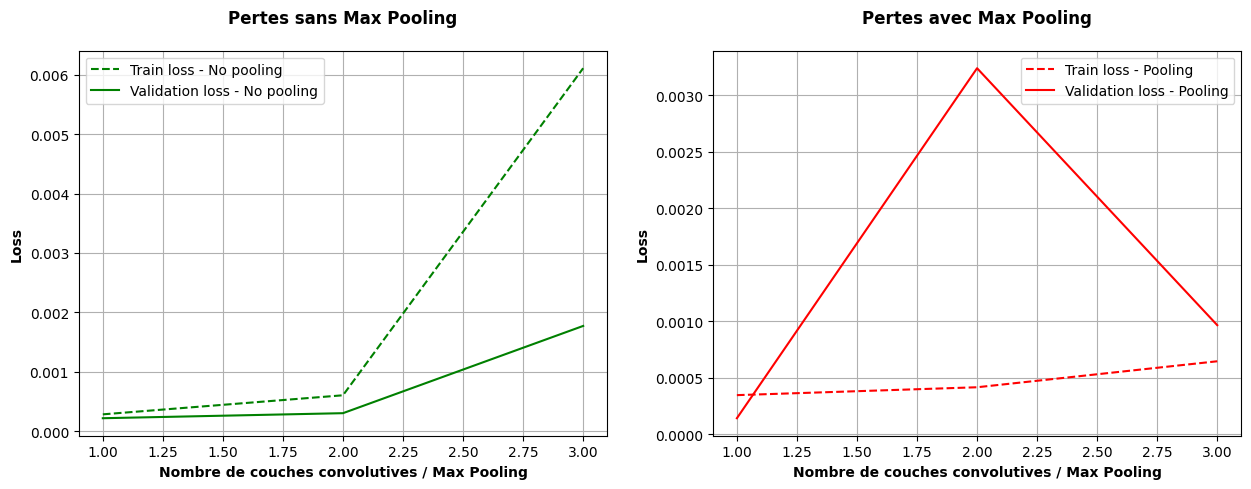

In [35]:
... code ...

**Bilan** : 

Dans le graphique de gauche, celui sans Max Pooling, on voit des loss largement inférieures à celles obtenues avec Max Pooling. Je n'ai pas laissé le détail, mais l'analyse plus poussée des modèles obtenus confirme ce résultat.

Nous n'allons donc **pas garder cette modification**, et nous contenter du meilleur moèle obtenu précédemment.

### D'autres manières de compléxifier ?

#### Continuer à compléxifier

J'aurais pu continuer encore à compléxifier et/ou à tester d'autres options, comme notamment le Dropour rate par exemple, mais cela m'a déjà pris énormément de temps à mettre en place, et à faire tourner tout ce code. De plus, le résultat obtenu montre l'efficacité de cette méthode.

Cependant, je n'ai pas trouvé cette méthode dès le début. J'avais commencé mon travail sur un autoencodeur, avant de me réorganiser et de passer sur cette analyse plus méthodique. Cela est intéressant de regarder malgré tout les résultats de cette technique, que j'ai adapté de codes plus complexes sans essayer d'améliorer les paramètres comme nous venons de le faire. 

Une méthode plus poussée vaut-elle mieux qu'une plus simple, mais qui a été mieux traitée ?

#### Mettre en place un Autoencodeur

L'étape C.3.5 commençait à faire un pont vers l'autoencodeur, mais ses résultats n'ont pas été satisfaisants. J'ai pendant longtemps essayé de mettre en place ce modèle, sans obtenir de résultats satisfaisants. J'aurais dû partir dès le début sur le modèle CNN simplifié, et le compléxifier ensuite pour atteindre naturellement un autoencodeur. 

Voici cependant un exemple du travail obtenu :

In [47]:
      # Mise en place : 
latent_dim = 400 # L'espace latent (j'ai essayé une large gamme de valeur, sans réussi à améliorer mon résultat sensiblement)

   # Encodeur
inputs    = keras.Input(shape=(26, 26, 1))
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(inputs) # La valeur de 64 n'est peut-être pas idéale
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
#encoder.summary()

   # Décodeur
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(13 * 13 * 32, activation="relu")(inputs)
x       = layers.Reshape((13, 13, 32))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
#decoder.summary()

   # Autoencodeur
inputs    = keras.Input(shape=(26, 26, 1)) # entrée = images initiales
latents   = encoder(inputs)
outputs   = decoder(latents)
ae = keras.Model(inputs,outputs, name="ae")
ae.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error') #mean_squared_error ou binary_crossentropy ?
#ae.summary()


   # Sauvegardes
# Sous-dossier pour l'autoencodeur
path = './Saves/Models/Autoencodeur'
if os.path.exists(path):
    shutil.rmtree(path)
os.makedirs(path)

fidle.utils.mkdir(path) # Callback = Best model = pour sauvegarder à chaque "epoch" le meilleur modèle
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath=path+'/best_model.h5', verbose=0, save_best_only=True)
callbacks_list = [callback_bestmodel]

   # On fait tourner le modèle
chrono = fidle.Chrono()
chrono.start()
history = ae.fit(X_train, Y_train,
                 batch_size      = 30, # Nombre d'images données à chaque epoch (cette valeur n'est peut-être pas optimale)
                 epochs          = 5,
                 verbose         = 1, # 0 : silencieux, 1 : bar de progression, 2 : encore plus. Verbose, pour verbe, à quel point il parle en tournant
                 validation_split=0.2,
                 callbacks       = callbacks_list  ) # A activer pour faire des sauvegardes du meilleur modèle
chrono.show()

In [51]:
... code ...

88/88 [==============================] - 1s 9ms/step

MSE avec ancien meilleur CNN  = 2.84e-05
MSE avec nouveau meilleur CNN = 1.94e-01


**BILAN ?**

On voit que le résultat est très décevant pour ce modèle d'autoencodeur : la MSE est 10 000 fois plus élevée qu'avec notre meilleur modèle de CNN basique.

Certainement qu'il aurait fallut tester plus en profondeur les différents paramètres, ou essayer d'autres structures de modèle, mais cela pourrait faire l'objet d'un autre travail.

Ainsi, même si la méthode de l'autoencodeur est considérée performante, l'appliquer bêtement reste bien moins efficace qu'une méthode plus simple mais mieux appliquée.

# Résultats / Applications
Observons désormais une compilation des résultats obtenus

## Comparaison finale de l'évolution des pertes

**Nous pouvons regrouper toutes nos loss dans un seul graphique comparatif**

In [ ]:
# On compile les différetes MSE
... code ...

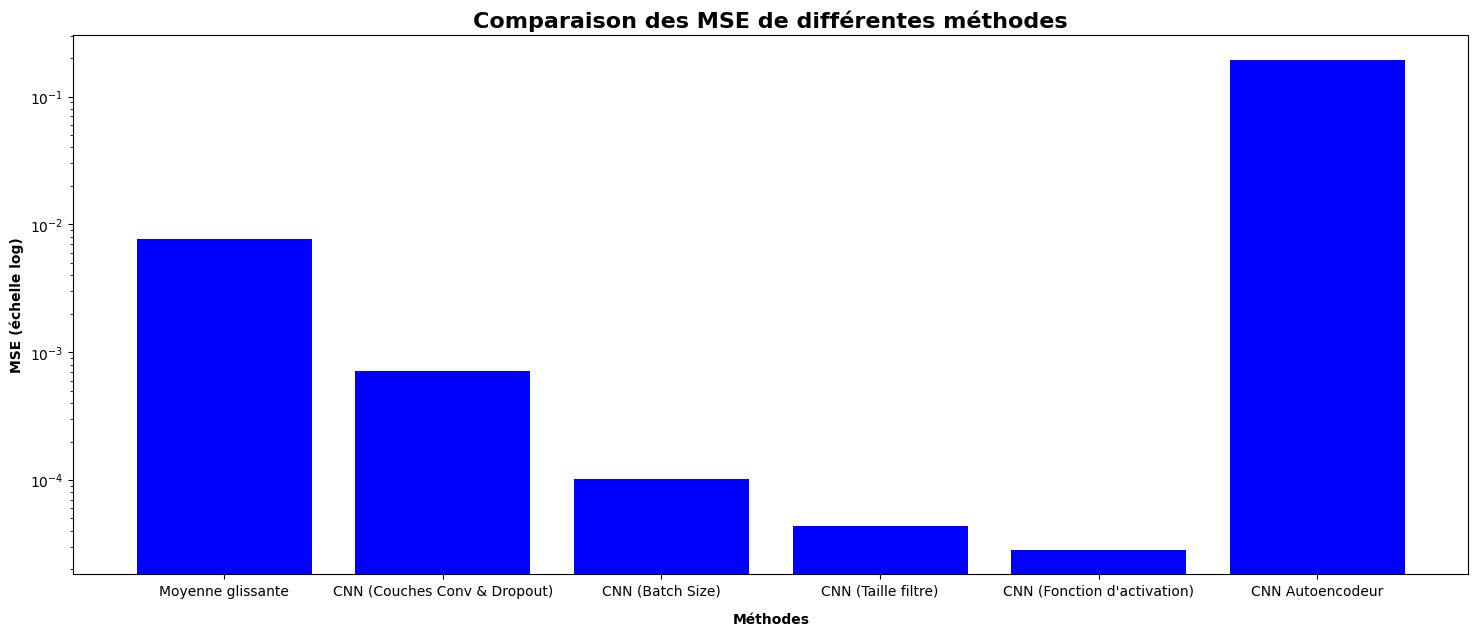

In [54]:
# On crée la figure finale
... code ...

**Dans le graphique ci-dessus, on oberve les loss pour chaque meilleur modèle obtenu au fil des étapes de notre méthode. On voit que l'amélioration progressive des paramètres a conduit à des résultats très satisfaisants, qui n'ont fait que s'améliorer.**

**L'autoencodeur est ridiculement peu efficace.**

## D.2 - Visualisations finales des produits des modèles

**Observons le résultat de l'utilisation des 6 modèles obtenus**

In [75]:
# Faire toutes les prédictions

pred_cnn_conv    = loaded_model_cnn_conv.predict(X_test)
pred_cnn_batch   = loaded_model_cnn_batch.predict(X_test)
pred_cnn_filter  = loaded_model_cnn_filter_size.predict(X_test)
pred_cnn_activ   = loaded_model_cnn_activation_fc.predict(X_test)
pred_cnn_autoenc = loaded_model_cnn_autoencodeur.predict(X_test)

88/88 [==============================] - 1s 9ms/step


In [86]:
i = 0 # Choisir le numéro de l'image à ploter

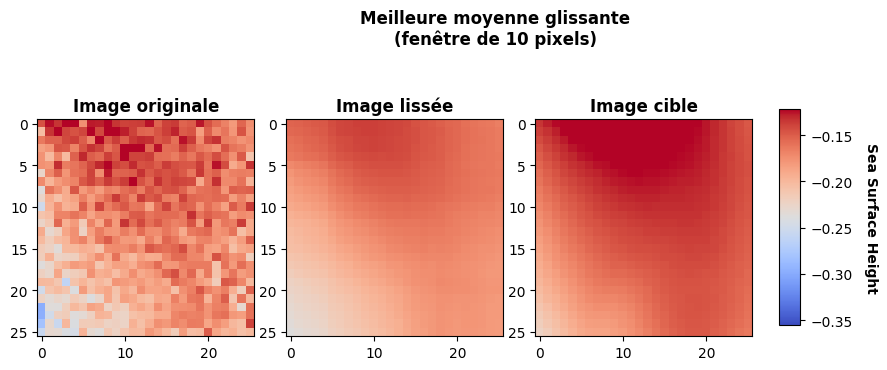

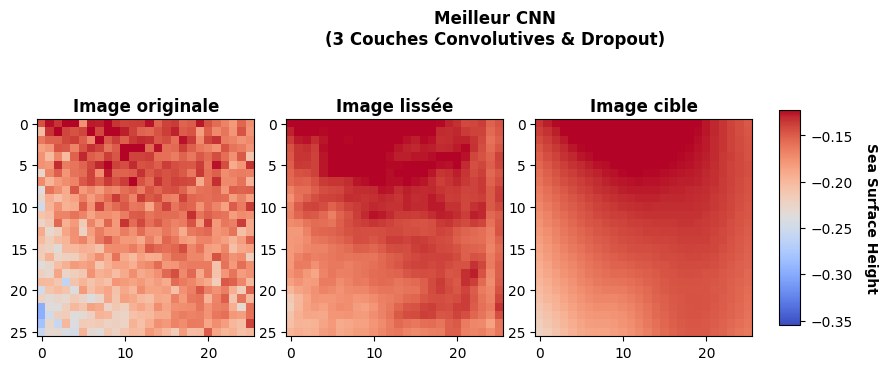

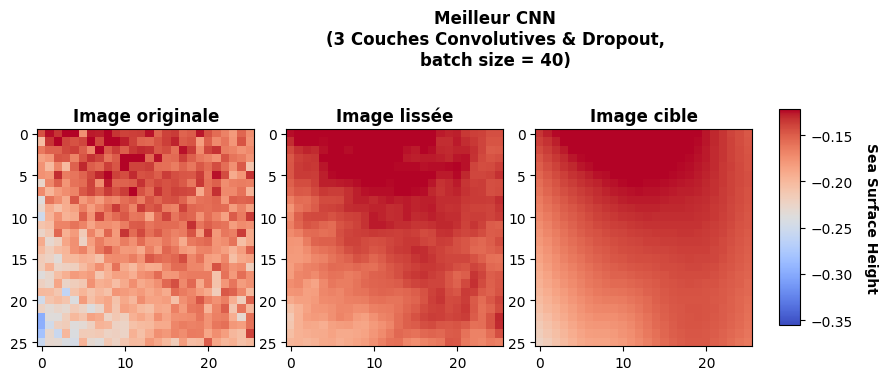

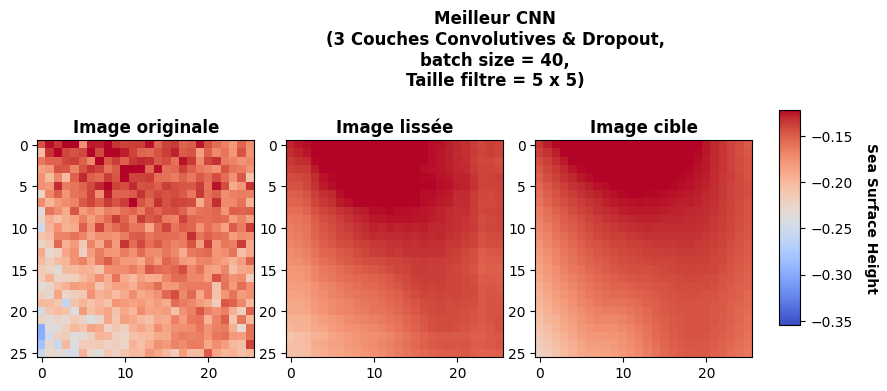

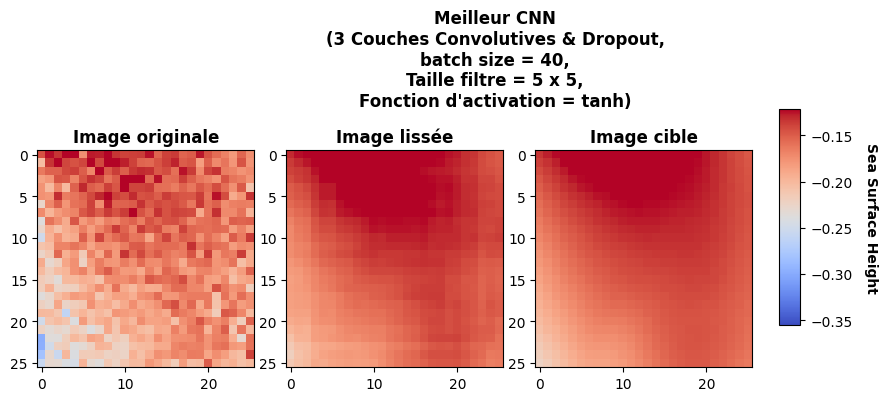

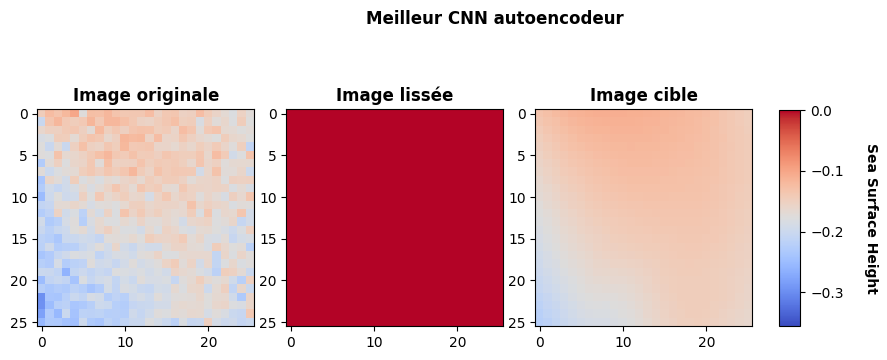

In [87]:
# Moyenne glissante
titre = 'Meilleure moyenne glissante\n(fenêtre de '+str(true_taille_fenêtre(taille_fenetre_index_choix))+' pixels)'
plot_comparatif(X_test, Y_test, moyenne_glissante(X_test[i], taille_fenetre_index_choix), i, titre,normalization_factor)

# CNN (Couches Conv & Dropout) # Toujours similaire, pas nécessaire de garder tout le code.
... code ...
# CNN (Batch Size)
... code ...
# CNN (Taille filtre)
... code ...
# CNN (Fonction d'activation)
... code ...
# CNN Autoencodeur'
... code ...

Une fois encore, ces graphiques nous montrent que les différences sont difficiles à observer à l'oeil nu, et que l'analyse statistique est nécessaire. On remarque simplement les différences entre les trois familles de modèles : moyenne glissante, CNN classique et CNN autoencodeur.

# E. Analyse des résultats & limitations

La compléxification progressive du CNN basique a donné ce chemin de modifications : 

![image](./Saves/Figures/Sum_up.png)

Les résultats sont très satisfaisants, nous avons obtenu un débruiteur efficace, seulement il y a beaucoup de questions qui restent en suspens. Si nous n'avions pas fait les étapes dans l'ordre utilisé ici, aurions-nous eu les mêmes résultats ?

C'est là un problème de fond : nous avons modifié les paramètres uns à uns, sans pour autant tester l'effet des combinaisons de paramètres. Peut-être par exemple qu'un grand batch size utilisé avec une fonction d'activation différente donnerait de meilleurs résultats. Le minimum de MSE que nous avons obtenu est un minimum, certes, mais pas forcément un minimum global. Pour obtenir un résultat plus satisfaisant, il serait intéressant de reprendre tout ce travail à zéro, et de modifier aléatoirement les paramètres selon leur gamme d'amplitude. 

Pour faire simple, ce serait une MCMC (Markov Chain Monte Carlo) que nous pourrions implémenter pour tester une multitude de combinaison de paramètres, pour dégager un optimum global. 

Cependant, même si mon meilleu modèle n'est pas le meilleur possible, il n'en reste pas moins très efficace pour débruiter les images. La direction choisie a été poussée efficacement.

**Suite**

Après avoir mis en place une MCMC, ou même simplement avec ce modèle, il aurait été intéressant de créer une fonction pour regrouper les images originelles, et ensuite tester ces images débruitées par rapport aux autres méthodes déjà mises en place et fournies dans le Github : https://github.com/ocean-data-challenges/2022a_SWOT_karin_error_filtering. Nous aurions alors aussi pu essayer la création de courants géostrophiques

# F. Bilan

## F.1. Difficultés rencontrées

J'ai trouvé difficile deux points principaux : 

* D'abord, se mettre au clair sur le format des données et comment les fournir au modèle n'est pas évident, et les rendez-vous avec E.Cosme m'ont beaucoup aidé dans ce sens.
* Ensuite, choisir une direction en machine learning m'a paru assez flou. J'ai choisi de faire les tests montrés ici parce qu'ils me semblaient les plus logiques, mais j'ai l'impression que l'on pourrait prendre des centaines de voies différentes. Choisir son modèle, comment le faire varier, sur quelles gammes de variations... beaucoup de choses différentes que l'on peut explorer.

## F.2. Skilld obtenus grâce au/pdt le projet

* J'ai appris à prendre en main les outils de machine learning, plus concrètement encore que dans le cours, où l'on suivait des exemples pré-conçus. Ce point m'a beaucoup plu.
* En termes d'organisation aussi, je n'avais pas encore eu de projets à tenir sur une si longue durée (autour de trois mois) en paralèlle d'autres activités. Je me suis rapidement organisé pour travailler au moins quelques heures par semaines, je suis content d'avoir réussi ce défi que je m'étais lancé.
* J'ai aussi pris du recul par rapport aux outils tels chatGPT. Je m'en suis servi au début, pour créer ma fonction de moyenne glissante, mais j'ai vite remarqué que je n'avais rien compris à ce que j'obtenais. J'ai alors très peu utilisé cet outil, à part pour améliorer des codes, ou les simplifier. Je pense que c'est une erreur facile que de se reposer sur eux et de ne pas comprendre le code obtenu, voire les résultats obtenus !
* Enfin, l'ordinateur portable prêté par E.Cosme m'a initié à Linux, et je pense y passer sur mon ordinateur personnel désormais. La découverte a été très positive !